In [10]:
# Finding States of Majorana Chain using DMRG

using ITensors, ITensorMPS, PythonPlot

# Number of states to find
global R = 4

# Length of the spin chain
global L = 30 

# Toggle energy offset
energy_offset = false

# Coupling coefficients
global lambdaI = 1
global lambda3 = 0.856

# Observer to monitor convergence
observer = DMRGObserver(; energy_tol=1e-10)

# Number of sweeps, bond dimensions, and cutoff for DMRG algorithm
nsweeps = 20
global maxdim = [10, 33, 66, 133, 200]
cutoff = 1e-10

let
    # Reset global variables
    global psi = []
    global energies = []
    global sorted_indices = []
    global overlap_matrix = nothing
    
    # Create L Spin-1/2 Indices
    global sites = siteinds("S=1/2", L)

    # Create the Hamiltonian (HI) of the Ising chain
    osI = OpSum()
    for j in 1:(L - 1)
        osI -= "X", j 
        osI -= "Z", j, "Z", j + 1
    end
    # Periodic terms
    osI -= "X", L
    osI -= "Z", L, "Z", 1
    HI = MPO(osI, sites)

    # Create the Hamiltonian (H3) of the three-spin interaction
    os3 = OpSum()
    for j in 1:(L - 2)
        os3 += "X", j, "Z", j + 1, "Z", j + 2
        os3 += "Z", j, "Z", j + 1, "X", j + 2
    end
    # Periodic terms
    os3 += "X", L - 1, "Z", L, "Z", 1
    os3 += "X", L, "Z", 1, "Z", 2
    os3 += "Z", L - 1, "Z", L, "X", 1
    os3 += "Z", L, "Z", 1, "X", 2
    H3 = MPO(os3, sites)

    # Toggle energy offset E0
    if energy_offset == true
        EO = L * (lambdaI^2 + lambda3^2) / lambda3
        osEO = OpSum()
        osEO += EO, "Id", 1
        E0 = MPO(osEO, sites)
        # Full Hamiltonian from paper
        global H = 2 * lambdaI * HI + lambda3 * H3 + E0
    else
        # Full Hamiltonian without energy offset
        global H = 2 * lambdaI * HI + lambda3 * H3
    end

    # Create an initial random matrix product state
    psi0 = random_mps(sites)

    println("Maxdim per sweep: ", maxdim)
    println()
    
    global psi = Vector{MPS}(undef, R)
    global energies = zeros(R)

    # Run DMRG once to find a ground state
    println("DMRG run 1:")
    energies[1], psi[1] = dmrg(H, psi0; nsweeps, maxdim, cutoff, observer=observer)
    println("Final energy for DMRG run 1: $(energies[1])")
    println()

    # Find subsequent states while forcing orthogonality
    for i in 2:R
        println("DMRG run $i:")
        energies[i], psi[i] = dmrg(H, psi[1:(i-1)], psi0; nsweeps, maxdim, cutoff, weight=100, observer=observer)
        println("Final energy for DMRG run $i: $(energies[i])")
        println()
    end

    # Sort and label the states
    global sorted_indices = sortperm(energies)

    println("Energy results from DMRG in ascending order:")
    for (i, idx) in enumerate(sorted_indices)
        println("State $i: $(energies[idx])")
    end
    
    # Analysis overlap between states; Return overlap matrix
    function analyze_overlaps(psi, sorted_indices...,)
        n_total = length(sorted_indices)
        overlap_matrix = zeros(ComplexF64, n_total, n_total)
        for (i, idx_i) in enumerate(sorted_indices)
            for (j, idx_j) in enumerate(sorted_indices)
                overlap_matrix[i, j] = inner(psi[idx_i], psi[idx_j])
            end
        end
        println("\nNormalizations:")
        for (i, idx) in enumerate(sorted_indices)
            norm_val = abs(overlap_matrix[i,i])
            println("State $i: ⟨ψ$idx|ψ$idx⟩ = $(round(norm_val, digits=8))")
        end
        println("\nInner product between states:")
        for i in 1:n_total
            for j in (i+1):n_total
                overlap_val = abs(overlap_matrix[i,j])
                println("⟨ψ$(sorted_indices[i])|ψ$(sorted_indices[j])⟩ = $overlap_val")
            end
        end
        return overlap_matrix
    end
    global overlap_matrix = analyze_overlaps(psi, sorted_indices...,)
nothing
end

Maxdim per sweep: [10, 33, 66, 133, 200]

DMRG run 1:
After sweep 1 energy=-59.58627531592016  maxlinkdim=4 maxerr=2.33E-16 time=0.016
After sweep 2 energy=-60.5854486981309  maxlinkdim=16 maxerr=6.49E-11 time=0.037
After sweep 3 energy=-60.68130950339608  maxlinkdim=52 maxerr=9.80E-11 time=0.215
After sweep 4 energy=-60.7206157465188  maxlinkdim=133 maxerr=1.20E-10 time=1.667
After sweep 5 energy=-60.742783250029056  maxlinkdim=192 maxerr=9.99E-11 time=3.735
After sweep 6 energy=-60.74931970648334  maxlinkdim=200 maxerr=1.09E-10 time=4.861
After sweep 7 energy=-60.75065756329863  maxlinkdim=200 maxerr=1.15E-10 time=4.866
After sweep 8 energy=-60.750872869991014  maxlinkdim=197 maxerr=1.07E-10 time=4.223
After sweep 9 energy=-60.75091375333519  maxlinkdim=189 maxerr=9.98E-11 time=4.411
After sweep 10 energy=-60.750921156296045  maxlinkdim=197 maxerr=9.98E-11 time=3.930
After sweep 11 energy=-60.75092249399174  maxlinkdim=189 maxerr=9.99E-11 time=3.883
After sweep 12 energy=-60.75092266

Evolving state 1 with energy: -60.750922693160184

Trotter step = 0.02
Total steps = 50

Final overlap with initial state: 0.986883
Final energy: -60.682601
Change in energy: 0.068322


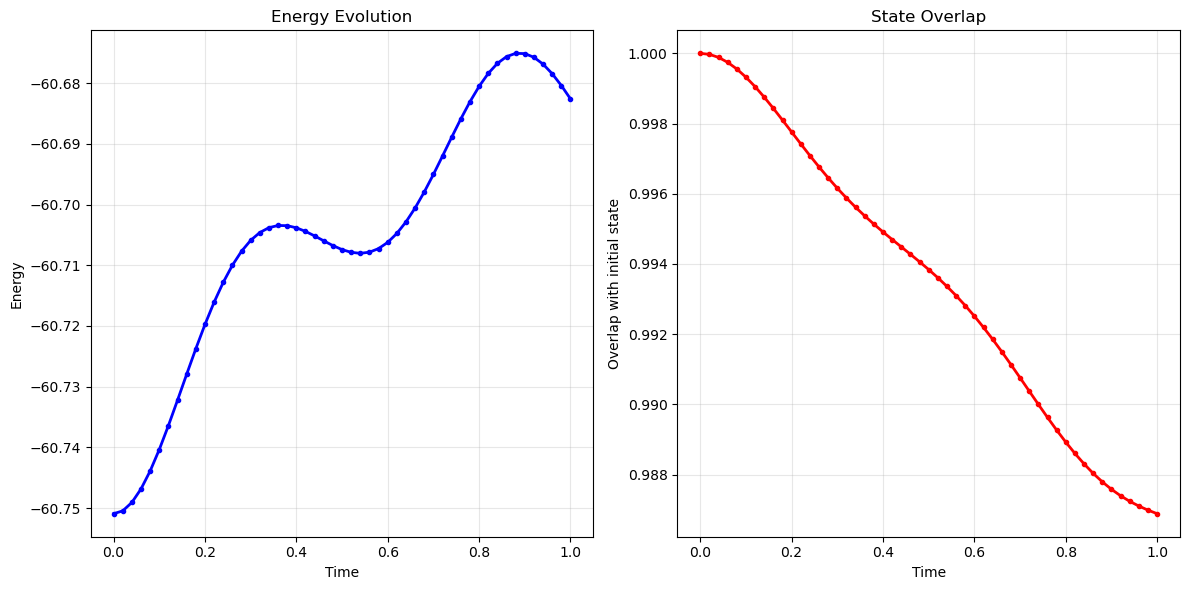

In [11]:
# Time Evolution Under Full Hamiltonian

using LinearAlgebra

# Choose which state to evolve
state_idx = 1
psi0 = psi[sorted_indices[state_idx]]
initial_energy = energies[sorted_indices[state_idx]]

println("Evolving state $state_idx with energy: $initial_energy")
println()

# Trotter step and total evolution time
tau = 0.02 
total_time = 1.0
n_steps = Int(total_time / tau)

println("Trotter step = $tau")
println("Total steps = $n_steps")
println()

# Build Trotter gates for the Hamiltonian
function build_trotter_gates(sites, tau)
    L = length(sites)
    gates = ITensor[]
    
# Three-spin gates (H3) half-step
    for j in 1:(L-2)
        s1, s2, s3 = sites[j], sites[j+1], sites[j+2]
        # Build term for Three-spin part of Hamiltonian
        H3_term = op("X", s1) * op("Z", s2) * op("Z", s3) +
                  op("Z", s1) * op("Z", s2) * op("X", s3)
        # Scale and create gate
        H3 = lambda3 * H3_term
        push!(gates, exp(-im * tau/2 * H3))
    end
    
    # Periodic conditions
    s1, s2, s3 = sites[L-1], sites[L], sites[1]
    H3_term = op("X", s1) * op("Z", s2) * op("Z", s3) +
              op("Z", s1) * op("Z", s2) * op("X", s3)
    H3 = lambda3 * H3_term
    push!(gates, exp(-im * tau/2 * H3))
    
    s1, s2, s3 = sites[L], sites[1], sites[2]
    H3_term = op("X", s1) * op("Z", s2) * op("Z", s3) +
              op("Z", s1) * op("Z", s2) * op("X", s3)
    H3 = lambda3 * H3_term
    push!(gates, exp(-im * tau/2 * H3))

# Two-site Ising gates (HI) full-step
    for j in 1:(L-1)
        s1, s2 = sites[j], sites[j+1]
        # Build term for Ising part of Hamiltonian
        HI_term = -op("X", s1) * op("Id", s2) -
                   op("Z", s1) * op("Z", s2)
        # Scale and create gate
        HI = 2 * lambdaI * HI_term
        push!(gates, exp(-im * tau * HI))
    end
    
    # Periodic conditions
    s1, s2 = sites[L], sites[1]
    HI_term = -op("X", s1) * op("Id", s2) -
               op("Z", s1) * op("Z", s2)
    HI = 2 * lambdaI * HI_term
    push!(gates, exp(-im * tau * HI))

# Three-spin gates (H3) half-step reverse
    
    # Periodic conditions
    s1, s2, s3 = sites[L], sites[1], sites[2]
    H3_term = op("X", s1) * op("Z", s2) * op("Z", s3) +
              op("Z", s1) * op("Z", s2) * op("X", s3)
    H3 = lambda3 * H3_term
    push!(gates, exp(-im * tau/2 * H3))
    
    s1, s2, s3 = sites[L-1], sites[L], sites[1]
    H3_term = op("X", s1) * op("Z", s2) * op("Z", s3) +
              op("Z", s1) * op("Z", s2) * op("X", s3)
    H3 = lambda3 * H3_term
    push!(gates, exp(-im * tau/2 * H3))
    
    for j in (L-2):-1:1
        s1, s2, s3 = sites[j], sites[j+1], sites[j+2]
        # Build term for Three-spin part of Hamiltonian
        H3_term = op("X", s1) * op("Z", s2) * op("Z", s3) +
                  op("Z", s1) * op("Z", s2) * op("X", s3)
        # Scale and create gate
        H3 = lambda3 * H3_term
        push!(gates, exp(-im * tau/2 * H3))
    end
    
    return gates
end

# Initialize by building gates once
t_gates = build_trotter_gates(sites, tau)

# Time evolution
psi_evolved = copy(psi0)
times = Float64[]
energy_vals = Float64[]
overlap_vals = Float64[]

# Initial conditions
push!(times, 0.0)
push!(energy_vals, real(inner(psi0', H, psi0)))
push!(overlap_vals, 1.0)

# Time evolution loop
for step in 1:n_steps
    # Apply one full Trotter step and normalize
    psi_evolved = apply(t_gates, psi_evolved; cutoff=cutoff, maxdim=maximum(maxdim))
    normalize!(psi_evolved)
    
    current_time = step * tau
    
    # Take measurement every 1 step(s) or at the end
    if step % 1 == 0 || step == n_steps
        energy = real(inner(psi_evolved', H, psi_evolved))
        overlap = abs(inner(psi0, psi_evolved))
        
        # Store for plotting
        push!(times, current_time)
        push!(energy_vals, energy)
        push!(overlap_vals, overlap)
    end
end

# Final results
final_overlap = overlap_vals[end]
final_energy = energy_vals[end]
println("Final overlap with initial state: $(round(final_overlap, digits=6))")
println("Final energy: $(round(final_energy, digits=6))")
println("Change in energy: $(round(abs(final_energy - initial_energy), digits=6))")

# Plotting
fig, (ax1, ax2) = PythonPlot.subplots(1, 2, figsize=(12, 6))

ax1.plot(times, energy_vals, "b.-", linewidth=2)
ax1.set_xlabel("Time")
ax1.set_ylabel("Energy")
ax1.grid(true, alpha=0.3)
ax1.set_title("Energy Evolution")

ax2.plot(times, overlap_vals, "r.-", linewidth=2)
ax2.set_xlabel("Time")
ax2.set_ylabel("Overlap with initial state")
ax2.grid(true, alpha=0.3)
ax2.set_title("State Overlap")

PythonPlot.tight_layout()
PythonPlot.show() 

Maximum and Minimum Correlations:
State 1: 0.637, 0.367
State 2: 0.669, 0.519
State 3: 0.63, -0.001
State 4: 0.605, -0.352


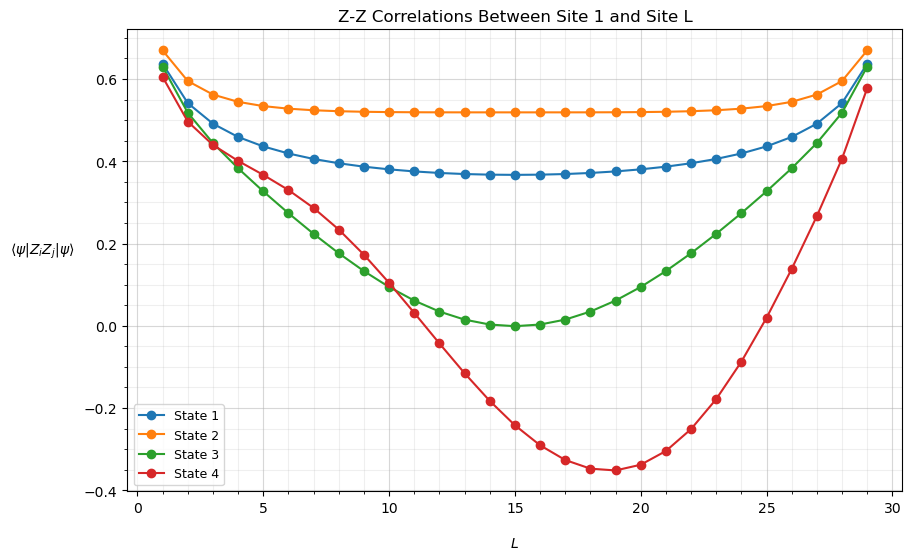

In [31]:
# Z-Z Correlations

using PythonPlot, LaTeXStrings

# Clear variables
ZZC = Vector{Matrix{ComplexF64}}(undef, R)
real_ZZC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute Z-Z correlations matrices for all states
for i in 1:R
    ZZC[i] = correlation_matrix(psi[sorted_indices[i]], "Z", "Z")
end

# Get the real values of correlations
for i in 1:R
    real_ZZC[i] = real.(ZZC[i][1, 2:end])
end

figure(figsize=(10, 6))

# Plot the Z-Z correlations for ground states
for i in 1:R
    x[i] = collect(1:length(real_ZZC[i]))
    plot(x[i], real_ZZC[i], marker="o", linestyle="-", linewidth=1.5, label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel(L"L", labelpad=15)
ylabel(L"\langle \psi | Z_i Z_j | \psi \rangle", rotation=0, labelpad=30)
title("Z-Z Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(real_ZZC[i]), digits=3)), $(round(minimum(real_ZZC[i]), digits=3))")
end

Maximum and Minimum Correlations:
State 1: 0.541, 0.407
State 2: 0.482, 0.362
State 3: 0.518, 0.397
State 4: 0.602, 0.392


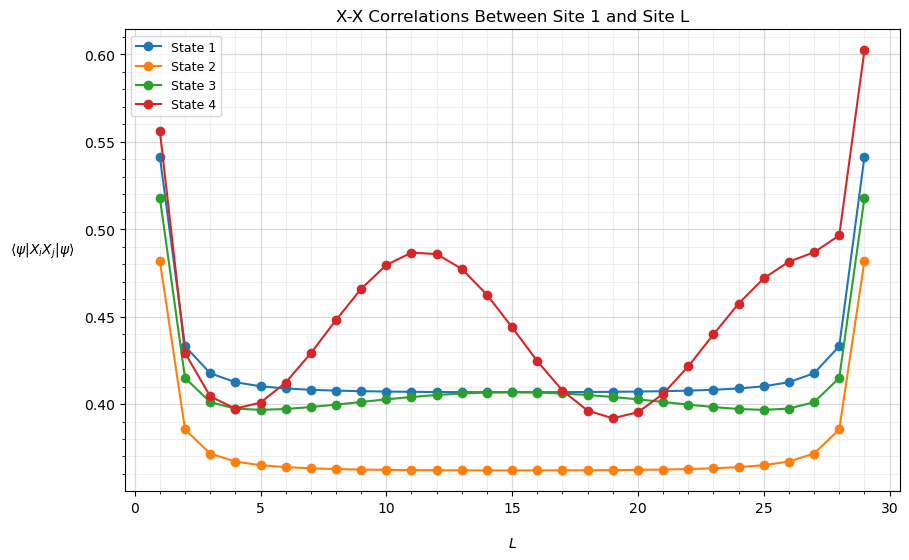

In [32]:
# X-X Correlations

using PythonPlot, LaTeXStrings

# Clear variables
XXC = Vector{Matrix{ComplexF64}}(undef, R)
real_XXC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute X-X correlations matrices for all states
for i in 1:R
    XXC[i] = correlation_matrix(psi[sorted_indices[i]], "X", "X")
end

# Get the real values of correlations
for i in 1:R
    real_XXC[i] = real.(XXC[i][1, 2:end])
end

figure(figsize=(10, 6))

# Plot the X-X correlations for ground states
for i in 1:R
    x[i] = collect(1:length(real_XXC[i]))
    plot(x[i], real_XXC[i], marker="o", linestyle="-", linewidth=1.5, label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel(L"L", labelpad=15)
ylabel(L"\langle \psi | X_i X_j | \psi \rangle", rotation=0, labelpad=30)
title("X-X Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(real_XXC[i]), digits=3)), $(round(minimum(real_XXC[i]), digits=3))")
end

Estimated slope of state 1: -0.2459
Estimated scaling dimension: 0.1229

Maximum and Minimum Connected Correlations:
State 1: 0.637, 0.367
State 2: 0.669, 0.519
State 3: 0.63, -0.001
State 4: 0.605, -0.352


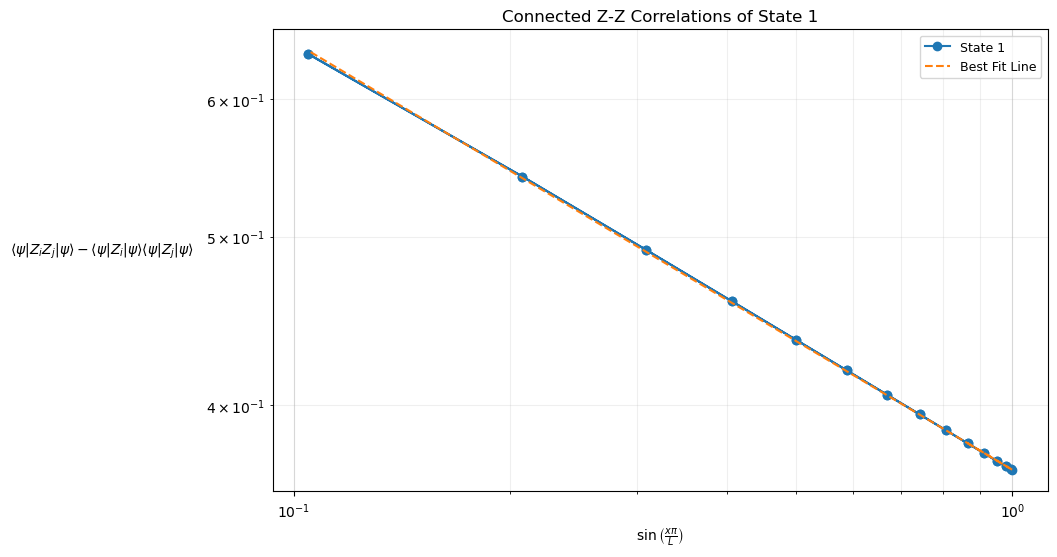

In [33]:
# Connected Z-Z Correlations

using PythonPlot, LaTeXStrings, Statistics

plot_toggle = true

# Select state to analyze (only relevant if plot_toggle = true)
select_state = 1

# Clear variables
ZZCC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute connected Z-Z correlations for all states
for i in 1:R
    corr_matrix = correlation_matrix(psi[sorted_indices[i]], "Z", "Z")
    Z_exp = [real(expect(psi[sorted_indices[i]], "Z"; sites=j)) for j in 1:L]

    ccorrs = Vector{Float64}(undef, L-1)
    for j in 2:L
        RHS = Z_exp[1] * Z_exp[j]
        ccorrs[j-1] = real(corr_matrix[1, j]) - RHS
    end
    ZZCC[i] = ccorrs
end

figure(figsize=(10, 6))

# Plot the connected Z-Z correlations
if plot_toggle == true
    # Plot the selected state in log-log mode
    x[select_state] = collect(1:length(ZZCC[select_state]))
    plot(sin.(x[select_state] .* pi ./ L), ZZCC[select_state],
         marker="o", linestyle="-", linewidth=1.5,
         label="State $(sorted_indices[select_state])")

    xscale("log"); yscale("log")
    xlabel(L"\sin{\left(\frac{x\pi}{L}\right)}")
    ylabel(L"\langle\psi|Z_iZ_j|\psi\rangle - \langle\psi|Z_i|\psi\rangle \langle\psi|Z_j|\psi\rangle", rotation=0, labelpad=75)
    title("Connected Z-Z Correlations of State $(sorted_indices[select_state])")

    # X and Y coordinates plotted on the log–log graph
    xvals = sin.(x[select_state] .* pi ./ L)
    yvals = ZZCC[select_state]

    # Filter out invalid points and take logs
    valid = findall(k -> xvals[k] > 0 && yvals[k] > 0 && k > 9, eachindex(xvals)) # Do not include the first 9 sites
    log_x = log.(xvals[valid])
    log_y = log.(yvals[valid])

    # Build regression matrix and solve least‑squares fit
    design_matrix = hcat(ones(length(log_x)), log_x)
    β = design_matrix \ log_y
    slope, intercept = β[2], β[1]

    # Print slope and scaling dimension
    println("Estimated slope of state $(sorted_indices[select_state]): ",
            round(slope, digits=4))
    println("Estimated scaling dimension: ",
            round(-slope/2, digits=4))
    println()

    # Overlay fit line
    plot(xvals[valid], exp.(intercept .+ slope .* log_x), "--", label="Best Fit Line")

else
    # Plot all states normally
    for i in 1:R
        x[i] = collect(1:length(ZZCC[i]))
        plot(x[i], ZZCC[i], marker="o", linestyle="-", linewidth=1.5,
             label="State $(sorted_indices[i])")
    end

    xlabel(L"L", labelpad=15)
    ylabel(L"\langle\psi|Z_iZ_j|\psi\rangle - \langle\psi|Z_i|\psi\rangle \langle\psi|Z_j|\psi\rangle", rotation=0, labelpad=75)
    title("Connected Z-Z Correlations Between Site 1 and Site L")
end

legend(fontsize=9)
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Connected Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): ",
            round(maximum(ZZCC[i]), digits=3), ", ",
            round(minimum(ZZCC[i]), digits=3))
end

Estimated slope of state 1: -2.087
Estimated scaling dimension: 1.0435

Maximum and Minimum Connected Correlations:
State 1: 0.136, 0.001
State 2: 0.119, -0.001
State 3: 0.121, -0.0
State 4: 0.139, -0.008


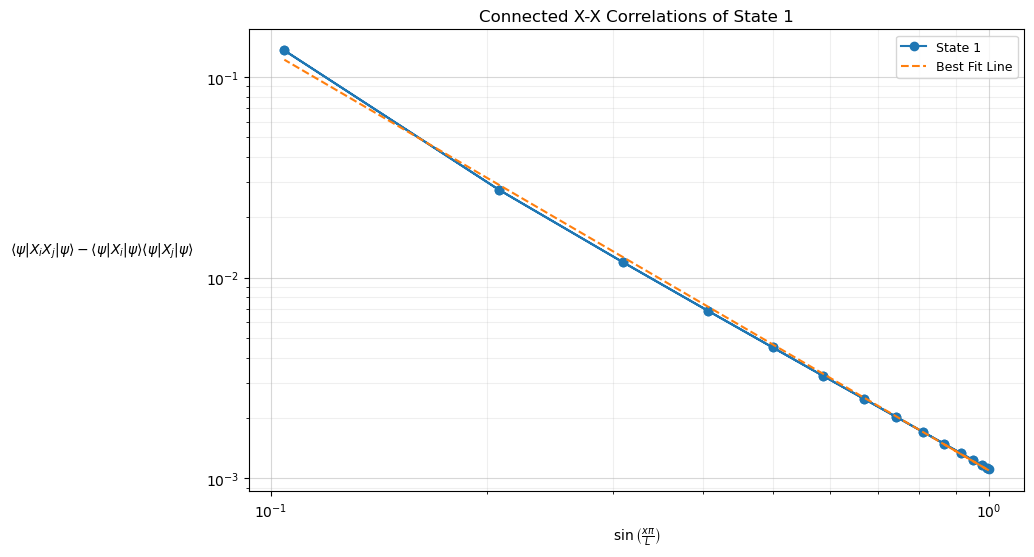

In [34]:
# Connected X-X Correlations

using PythonPlot, LaTeXStrings, Statistics

plot_toggle = true

# Select state to analyze (only relevant if plot_toggle = true)
select_state = 1

# Clear variables
XXCC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute connected X-X correlations for all states
for i in 1:R
    corr_matrix = correlation_matrix(psi[sorted_indices[i]], "X", "X")
    X_exp = [real(expect(psi[sorted_indices[i]], "X"; sites=j)) for j in 1:L]

    ccorrs = Vector{Float64}(undef, L-1)
    for j in 2:L
        RHS = X_exp[1] * X_exp[j]
        ccorrs[j-1] = real(corr_matrix[1, j]) - RHS
    end
    XXCC[i] = ccorrs
end

figure(figsize=(10, 6))

# Plot the connected X-X correlations
if plot_toggle == true
    # Plot the selected state in log-log mode
    x[select_state] = collect(1:length(XXCC[select_state]))
    plot(sin.(x[select_state] .* pi ./ L), XXCC[select_state],
         marker="o", linestyle="-", linewidth=1.5,
         label="State $(sorted_indices[select_state])")

    xscale("log"); yscale("log")
    xlabel(L"\sin{\left(\frac{x\pi}{L}\right)}")
    ylabel(L"\langle\psi|X_iX_j|\psi\rangle - \langle\psi|X_i|\psi\rangle \langle\psi|X_j|\psi\rangle", rotation=0, labelpad=75)
    title("Connected X-X Correlations of State $(sorted_indices[select_state])")

    # X and Y coordinates plotted on the log–log graph
    xvals = sin.(x[select_state] .* pi ./ L)
    yvals = XXCC[select_state]

    # Filter out invalid points and take logs
    valid = findall(k -> xvals[k] > 0 && yvals[k] > 0 && k > 9, eachindex(xvals)) # Do not include the first 9 sites
    log_x = log.(xvals[valid])
    log_y = log.(yvals[valid])

    # Build regression matrix and solve least‑squares fit
    design_matrix = hcat(ones(length(log_x)), log_x)
    β = design_matrix \ log_y
    slope, intercept = β[2], β[1]

    # Print slope and scaling dimension
    println("Estimated slope of state $(sorted_indices[select_state]): ",
            round(slope, digits=4))
    println("Estimated scaling dimension: ",
            round(-slope/2, digits=4))
    println()

    # Overlay fit line
    plot(xvals[valid], exp.(intercept .+ slope .* log_x), "--", label="Best Fit Line")

else
    # Plot all states normally
    for i in 1:R
        x[i] = collect(1:length(XXCC[i]))
        plot(x[i], XXCC[i], marker="o", linestyle="-", linewidth=1.5,
             label="State $(sorted_indices[i])")
    end

    xlabel(L"L", labelpad=15)
    ylabel(L"\langle\psi|X_iX_j|\psi\rangle - \langle\psi|X_i|\psi\rangle \langle\psi|X_j|\psi\rangle", rotation=0, labelpad=75)
    title("Connected X-X Correlations Between Site 1 and Site L")
end

legend(fontsize=9)
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Connected Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): ",
            round(maximum(XXCC[i]), digits=3), ", ",
            round(minimum(XXCC[i]), digits=3))
end